# NLP Continue (Text Classification)

In [1]:
# getting the data

!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2024-06-14 17:26:56--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-06-14 17:26:57 (92.5 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [2]:
from helper_functions import unzip_data, create_tensorboard_callback, plot_loss_curves, compare_historys

# Getting the dataset for binary text classification

In [3]:
!wget https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip

--2024-06-14 17:27:28--  https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.2.207, 74.125.137.207, 142.250.101.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.2.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 607343 (593K) [application/zip]
Saving to: ‘nlp_getting_started.zip’

nlp_getting_started 100%[===================>] 593.11K  --.-KB/s    in 0.005s  

2024-06-14 17:27:29 (111 MB/s) - ‘nlp_getting_started.zip’ saved [607343/607343]



In [4]:
unzip_data("nlp_getting_started.zip")

# Visualizing the dataset

In [5]:
import pandas as pd

train_df = pd.read_csv("train.csv")

In [6]:
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [7]:
train_df["target"].value_counts()

target
0    4342
1    3271
Name: count, dtype: int64

In [8]:
train_df_shuffled = train_df.sample(frac=1, random_state=2)
train_df_shuffled.head()

,id,keyword,location,text,target
3190,4579,emergency%20plan,North Hastings Ontario,Practice your families fire escape plan so eve...,0
6171,8801,sirens,"Nomad, USA",Fuck Sleeping With Sirens.,0
1196,1722,buildings%20burning,NaN,'i'm a Gemini' *children screaming buildings b...,1
680,982,blazing,"Pig Symbol, Alabama",Montgomery come for the blazing hot weather......,1
3358,4808,evacuated,NaN,I got evacuated from the cinema 30 mins throug...,0


In [9]:
## Visualizing the random training examples

import random

random_index = random.randint(0, len(train_df) -5)

for row in train_df_shuffled[["text", "target"]][random_index:random_index+5].itertuples():
  _, text, target = row
  print(f"Target: {target}", "(real disaster)" if target > 0 else "(not real disaster)")
  print(f"Text:\n{text}\n")
  print("_______________________________________________________________")

Target: 1 (real disaster)
Text:
Residents in the central part of Ocean City heard from engineers about flood mitigation options Tuesday #OCNJ... http://t.co/jzPrCIqa9D

_______________________________________________________________
Target: 1 (real disaster)
Text:
Malaysia Airlines Flight 370 that Disappeared 17months ago Debris Found South of The Indian Ocean - http://t.co/nrHURYSyPd

_______________________________________________________________
Target: 1 (real disaster)
Text:
Skinny Jeans are Hazardous for Your Health! #socialnews http://t.co/LTMa9xQXpx

_______________________________________________________________
Target: 0 (not real disaster)
Text:
Crash helmet silvery floors karnal fat shoot sampling 33: PBCaNPCx

_______________________________________________________________
Target: 1 (real disaster)
Text:
@SophieWisey I couldn't. #mudslide

_______________________________________________________________


# Splitting the dataset into training and validation dataset

In [13]:
from sklearn.model_selection import train_test_split

In [14]:
train_sentences, val_sentences, train_labels, val_labels = train_test_split(
    train_df_shuffled["text"].to_numpy(),
    train_df_shuffled["target"].to_numpy(),
    test_size=0.1,
    random_state=2
)

In [15]:
train_sentences[:10]

array(['We have different moral systems. Mine rejects the mass murder of innocents yours explicitly endorses such behavior. https://t.co/qadRKEJZ9T',
       '@tsunami_esh ?? hey Esh',
       'On the sneak America has us spoiled. A natural disaster will humble niggas.',
       '~ More wicked weather rolls through Calgary and surrounding areas http://t.co/SxwJyR3K3l http://t.co/aEWGlVqReH',
       '@b24fowler I see that! Crazy how this line blew up.',
       'Watch This Airport Get Swallowed Up By A Sandstorm In Under A Minute http://t.co/BB7TTdVJWE',
       "Hey @reddit - the concept of a 'quarantine' makes no sense if the people you've quarantined can just wander out &amp; about whenever they want",
       'Major Hamayun Shaheed pilot of MI-7 heli that crashed in Mansehra http://t.co/2z8UbsY5M8',
       'Petition | Heartless owner that whipped horse until it collapsed is told he can KEEP his animal! Act Now! http://t.co/nJRjxqBjr4',
       'Housing Starts Explode to NewåÊHeights http:/

# Tokenization

In [16]:
import tensorflow as tf
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

In [17]:
text_vectorizer = TextVectorization(
    max_tokens=None,
    standardize="lower_and_strip_punctuation",
    split="whitespace",
    ngrams=None,
    output_mode="int",
    output_sequence_length=None
)

In [18]:
round(sum([len(i.split()) for i in train_sentences]) / len(train_sentences))

15

In [19]:
max_vocab_length = 10000
max_length = 15

text_vectorizer = TextVectorization(
    max_tokens=max_vocab_length,
    output_sequence_length=max_length,
    pad_to_max_tokens=True
)

In [20]:
text_vectorizer.adapt(train_sentences)

In [21]:
words_in_vocabulary = text_vectorizer.get_vocabulary()
top_5_words = words_in_vocabulary[:5]
bottom_5_words = words_in_vocabulary[-5:]

In [22]:
print(f"Number of words in vocabulary: {len(words_in_vocabulary)}")
print(f"Top 5 most common words: {top_5_words}")
print(f"Bottom 5 most common words: {bottom_5_words}")

Number of words in vocabulary: 10000
Top 5 most common words: ['', '[UNK]', 'the', 'a', 'in']
Bottom 5 most common words: ['palm', 'palinfoen', 'palestinian\x89Û', 'paleface', 'pale']


# Embedding

In [23]:
from tensorflow.keras import layers

embedding = layers.Embedding(
    input_dim = max_vocab_length,
    output_dim = 128,
    input_length = max_length
)

In [24]:
random_sentence = random.choice(train_sentences)

print(f"Original text:\n{random_sentence}\
      \n\nEmbedded version:")

sample_embed = embedding(text_vectorizer([random_sentence]))

sample_embed

Original text:
@tremblayeh we like big hail and we cannot lie!! #SirMixAlot      

Embedded version:


<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[ 0.04198415, -0.0246522 , -0.00416289, ..., -0.02906585,
         -0.03787206, -0.03656734],
        [-0.00952314,  0.00712347, -0.02777809, ...,  0.02760195,
         -0.02632035, -0.02949177],
        [ 0.00404742, -0.03959502, -0.01815403, ...,  0.01299138,
         -0.04904851, -0.04009278],
        ...,
        [-0.03863263,  0.02453411,  0.04939928, ..., -0.04052705,
         -0.02963551, -0.01767313],
        [-0.03863263,  0.02453411,  0.04939928, ..., -0.04052705,
         -0.02963551, -0.01767313],
        [-0.03863263,  0.02453411,  0.04939928, ..., -0.04052705,
         -0.02963551, -0.01767313]]], dtype=float32)>

In [26]:
sample_embed.shape

# 1 sample
# 15 tokens
# 128 vector each

TensorShape([1, 15, 128])

# Modelling

* Model 0: Naive Bayes ✅
* Model 1: Feed-Forward neural network (dense model) ✅
* Model 2: LSTM ✅
* Model 3: GRU ✅
* Model 4: Bidirectional-LSTM ✅
* Model 5: 1D Convolutional Neural Network ✅
* Model 6: Tensorflow Hub Pretrained Feature Extractor (using transfer learnig for NLP) ✅
* Model 7: Same as model 6 with 10% of training data

# Tensor Hub Pretrained Feature Extractor

In [27]:
import tensorflow_hub as hub
import tensorflow as tf

embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

In [28]:
embed_sample = embed(["This is for testing the embedding model."])
embed_sample.shape

TensorShape([1, 512])

In [29]:
embed_sample[0][:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([ 0.02723489,  0.04778206, -0.06898488, -0.06507987, -0.08099614,
       -0.01525011, -0.04238477,  0.04320183,  0.07985535,  0.03871179],
      dtype=float32)>

In [30]:
# creating keras layers for the pretrained embedding from tensorflow hub

sentence_encoder_layer = hub.KerasLayer(
    "https://tfhub.dev/google/universal-sentence-encoder/4",
    input_shape=[],
    dtype=tf.string,
    trainable=False
)

In [31]:
model_6 = tf.keras.Sequential([
    sentence_encoder_layer,
    layers.Dense(64, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])

In [32]:
model_6.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 512)               256797824 
                                                                 
 dense (Dense)               (None, 64)                32832     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 256830721 (979.73 MB)
Trainable params: 32897 (128.50 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


In [36]:
model_6.compile(
    loss = "binary_crossentropy",
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ["accuracy"]
)

model_6_history = model_6.fit(
    train_sentences,
    train_labels,
    epochs = 5,
    validation_data = (val_sentences, val_labels)
)

# Trained 5 epochs for 3 times

Epoch 1/5
215/215 [==============================] - 4s 13ms/step - loss: 0.3478 - accuracy: 0.8488 - val_loss: 0.4195 - val_accuracy: 0.8150
Epoch 2/5
215/215 [==============================] - 2s 11ms/step - loss: 0.3402 - accuracy: 0.8518 - val_loss: 0.4245 - val_accuracy: 0.8110
Epoch 3/5
215/215 [==============================] - 2s 12ms/step - loss: 0.3327 - accuracy: 0.8545 - val_loss: 0.4259 - val_accuracy: 0.8110
Epoch 4/5
215/215 [==============================] - 4s 19ms/step - loss: 0.3263 - accuracy: 0.8558 - val_loss: 0.4253 - val_accuracy: 0.8123
Epoch 5/5
215/215 [==============================] - 2s 12ms/step - loss: 0.3195 - accuracy: 0.8612 - val_loss: 0.4260 - val_accuracy: 0.8071


# Model 7: 10% of data with TF HUB Pretrained USE

In [37]:
# Create 10 percent of the dataset
# This will cause data leakage why ? see below

train_10_percent = train_df_shuffled[["text", "target"]].sample(frac=0.1, random_state=2)

In [44]:
train_sentences_10_percent = train_10_percent["text"].to_list()
train_sentences_10_percent[110:115]

['Ways so archetype a bleeding well-grounded readiness: FpOJ http://t.co/WXbrArc7p3',
 'looks like a year of writing and computers is ahead. http://t.co/CyXbrZXWq4',
 '2 Injured 1 missing in bridge collapse in central Mexico - Fox News Latino http://t.co/l0UnaFLy0Y',
 '&gt;&gt; $15 Aftershock : Protect Yourself and Profit in the Next Global Financial... ##book http://t.co/f6ntUc734Z\n@esquireattire',
 'Going to a fest? Bring swimming goggles for the dust storm in the circle pit']

In [46]:
train_labels_10_percent = train_10_percent["target"].to_list()
train_labels_10_percent[110:115]

[0, 0, 1, 0, 1]

In [49]:
len(train_sentences_10_percent), len(train_labels_10_percent)

(761, 761)

In [50]:
# check the number of targets in our subset of data
# comparing the ratio split with the original dataset

# 407/354 compare with 4342/3271

train_10_percent["target"].value_counts()

target
0    407
1    354
Name: count, dtype: int64

In [51]:
train_df_shuffled["target"].value_counts()

target
0    4342
1    3271
Name: count, dtype: int64

In [52]:
# Building the model

# to recreate a model the same as previous model we can use the tf.keras.models.clone_model method

model_7 = tf.keras.models.clone_model(model_6)

In [53]:
model_7.summary()
# This will not take any trained parameters only it takes the model architecture

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 512)               256797824 
                                                                 
 dense (Dense)               (None, 64)                32832     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 256830721 (979.73 MB)
Trainable params: 32897 (128.50 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


In [54]:
model_7.compile(
    loss = "binary_crossentropy",
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ["accuracy"]
)

model_7_history = model_7.fit(
    train_sentences_10_percent,
    train_labels_10_percent,
    epochs = 5,
    validation_data = (val_sentences, val_labels)
)

Epoch 1/5
24/24 [==============================] - 4s 65ms/step - loss: 0.6643 - accuracy: 0.6859 - val_loss: 0.6231 - val_accuracy: 0.7743
Epoch 2/5
24/24 [==============================] - 1s 48ms/step - loss: 0.5870 - accuracy: 0.7832 - val_loss: 0.5414 - val_accuracy: 0.7927
Epoch 3/5
24/24 [==============================] - 0s 20ms/step - loss: 0.5110 - accuracy: 0.7845 - val_loss: 0.4697 - val_accuracy: 0.7927
Epoch 4/5
24/24 [==============================] - 0s 20ms/step - loss: 0.4528 - accuracy: 0.7924 - val_loss: 0.4248 - val_accuracy: 0.8031
Epoch 5/5
24/24 [==============================] - 0s 20ms/step - loss: 0.4151 - accuracy: 0.8055 - val_loss: 0.3939 - val_accuracy: 0.8215


<Axes: >

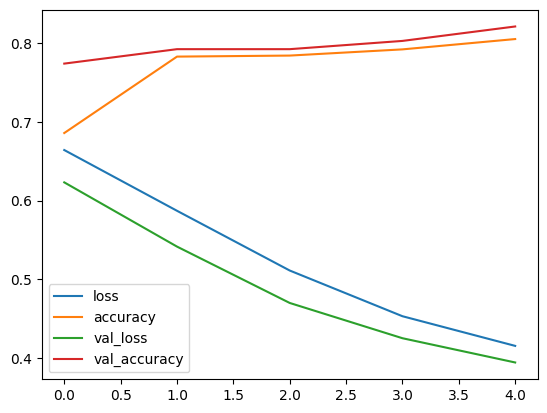

In [55]:
pd.DataFrame(model_7_history.history).plot()

In [56]:
model_7_pred_probs = model_7.predict(val_sentences)
model_7_preds = tf.squeeze(tf.round(model_7_pred_probs))

24/24 [==============================] - 1s 20ms/step


In [57]:
model_7_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([1., 0., 1., 1., 0., 0., 0., 1., 1., 1.], dtype=float32)>

In [58]:
## Creating a function to track evaluation methods
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def evaluate_preds(y_true, y_pred):
  """Evaluate your prediction

  parameters:
  y_true = true labels
  y_pred = predicted labels
  """
  accuracy = accuracy_score(y_true, y_pred) * 100
  precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average = "weighted")

  model_results = {
      "accuracy": accuracy,
      "precision": precision * 100,
      "recall": recall * 100,
      "f1": f1 * 100
  }
  return model_results

In [59]:
evaluate_preds(val_labels, model_7_preds)

{'accuracy': 82.1522309711286,
 'precision': 82.14644403512753,
 'recall': 82.1522309711286,
 'f1': 82.14876963356923}

# Why model 7 trained on 10% is performing better than model 6 trained on 100% data ?

Data Leakage problem because train_sentences and val_sentences are taken from shuffled train_data and then 10 percent data is taken from train_df_shuffled which also might contain some val_sentences because they are shuffled and selected so our new 10 percent data might contain val_sentences data so this might be the reason why our model is making more accuracy while training in 10% data than training our model in 100% data . This is **Data Leakage** problem

# Data Leakage Problem Solving

In [63]:
# making a better data split: no data leakage

train_10_percent_split = int(0.1 * len(train_sentences))
train_10_percent_split, len(train_sentences)

(685, 6851)

In [66]:
train_sentences_10_percent = train_sentences[:train_10_percent_split]

In [67]:
train_labels_10_percent = train_labels[:train_10_percent_split]

In [68]:
len(train_sentences_10_percent), len(train_labels_10_percent)

(685, 685)

In [70]:
train_sentences_10_percent[10], train_labels_10_percent[10]

("#Russia 'food crematoria' provoke outrage in country w/soaring poverty +Soviet famine memory http://t.co/vymOuZjZRe http://t.co/eNRJh5Qkve",
 1)

In [73]:
import numpy as np
pd.Series(np.array(train_labels_10_percent)).value_counts()

0    385
1    300
Name: count, dtype: int64

In [74]:
model_7_final = tf.keras.models.clone_model(model_6)
model_7_final.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 512)               256797824 
                                                                 
 dense (Dense)               (None, 64)                32832     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 256830721 (979.73 MB)
Trainable params: 32897 (128.50 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


In [76]:
model_7_final.compile(
    loss = "binary_crossentropy",
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ["accuracy"]
)

model_7_final_history = model_7_final.fit(
    train_sentences_10_percent,
    train_labels_10_percent,
    epochs = 5,
    validation_data = (val_sentences, val_labels)
)

Epoch 1/5
22/22 [==============================] - 7s 78ms/step - loss: 0.6652 - accuracy: 0.7358 - val_loss: 0.6368 - val_accuracy: 0.7730
Epoch 2/5
22/22 [==============================] - 0s 22ms/step - loss: 0.5977 - accuracy: 0.8073 - val_loss: 0.5775 - val_accuracy: 0.7887
Epoch 3/5
22/22 [==============================] - 0s 20ms/step - loss: 0.5310 - accuracy: 0.8117 - val_loss: 0.5249 - val_accuracy: 0.7743
Epoch 4/5
22/22 [==============================] - 0s 21ms/step - loss: 0.4768 - accuracy: 0.8117 - val_loss: 0.4900 - val_accuracy: 0.7795
Epoch 5/5
22/22 [==============================] - 0s 22ms/step - loss: 0.4382 - accuracy: 0.8190 - val_loss: 0.4730 - val_accuracy: 0.7835


# Experimentation results

In [81]:
model_result = pd.DataFrame({"model_7_result": evaluate_preds(val_labels, model_7_preds),
                             "model_7_result_another": evaluate_preds(val_labels, model_7_preds),
                             "Just for test to show all": evaluate_preds(val_labels, model_7_preds)})
model_result

,model_7_result,model_7_result_another,Just for test to show all
accuracy,82.152231,82.152231,82.152231
precision,82.146444,82.146444,82.146444
recall,82.152231,82.152231,82.152231
f1,82.148770,82.148770,82.148770


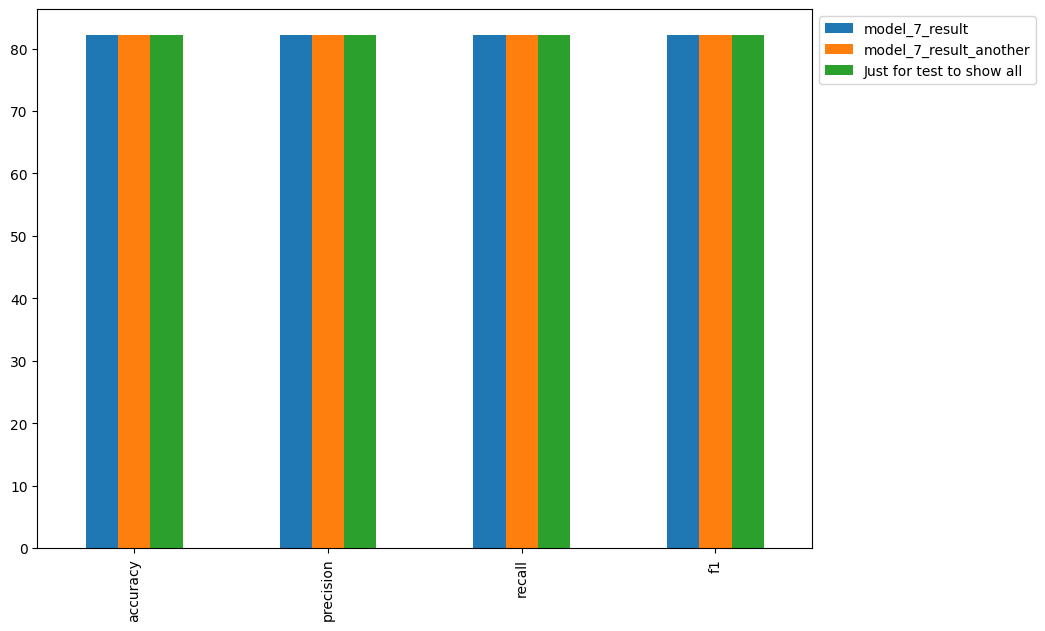

In [82]:
model_result.plot(kind = "bar", figsize = (10, 7)).legend(bbox_to_anchor = (1.0, 1.0))

# Saving our model

There are two main formats to save a model to in Tenosrflow

* The HDF5 format (compatible when using other library than tf)
* The `Saved Model` is the default

In [83]:
# saving model in HDF5 format

model_7_final.save("model_6.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [85]:
# Load the model with custom Hub Layer (required HDF5 format)
import tensorflow_hub as hub

# custom object means hub coming for embedding layer
loaded_model_7_final = tf.keras.models.load_model("model_6.h5",
                                                 custom_objects = {"KerasLayer": hub.KerasLayer})


In [86]:
loaded_model_7_final.evaluate(val_sentences, val_labels)

24/24 [==============================] - 1s 17ms/step - loss: 0.4730 - accuracy: 0.7835


[0.4730122983455658, 0.7834645509719849]

In [87]:
# saving to the saved model format

model_7_final.save("model_7_final")

# This will save in a folder (assets, variables, saved model.pb)

In [88]:
# loading a model from the saved model format

loaded_model_7 = tf.keras.models.load_model("model_7_final")

# dont need to pass custom object in this saved model format

In [89]:
loaded_model_7.evaluate(val_sentences, val_labels)

24/24 [==============================] - 2s 24ms/step - loss: 0.4730 - accuracy: 0.7835


[0.4730122983455658, 0.7834645509719849]

# download files from colab

download manually or write script

# Finding the most wrong examples

* If our best model still is not perfect what examples is it getting wrong?
* And of these wrong examples which ones is it getting most wrong (those with prediction probabilities closest to the opposite class)

For example if a sample should have a label of 0 but our model predicts a prediction probability of 0.999 (really close to 1) and vice versa

This is called model driven data exploration / active learning

In [91]:
# Download a pretrained model from Google Storage

!wget https://storage.googleapis.com/ztm_tf_course/08_model_6_USE_feature_extractor.zip

--2024-06-14 18:52:07--  https://storage.googleapis.com/ztm_tf_course/08_model_6_USE_feature_extractor.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.141.207, 142.251.2.207, 74.125.137.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.141.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 960779165 (916M) [application/zip]
Saving to: ‘08_model_6_USE_feature_extractor.zip’

08_model_6_USE_feat 100%[===================>] 916.27M  71.4MB/s    in 19s     

2024-06-14 18:52:26 (48.5 MB/s) - ‘08_model_6_USE_feature_extractor.zip’ saved [960779165/960779165]



In [92]:
!unzip 08_model_6_USE_feature_extractor.zip

Archive:  08_model_6_USE_feature_extractor.zip
   creating: 08_model_6_USE_feature_extractor/
   creating: 08_model_6_USE_feature_extractor/assets/
   creating: 08_model_6_USE_feature_extractor/variables/
  inflating: 08_model_6_USE_feature_extractor/variables/variables.data-00000-of-00001  
  inflating: 08_model_6_USE_feature_extractor/variables/variables.index  
  inflating: 08_model_6_USE_feature_extractor/saved_model.pb  


In [93]:
best_model = tf.keras.models.load_model("08_model_6_USE_feature_extractor")

In [94]:
best_model.summary()

Model: "model_6_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_11 (Dense)            (None, 64)                32832     
                                                                 
 output_layer (Dense)        (None, 1)                 65        
                                                                 
Total params: 256830721 (979.73 MB)
Trainable params: 32897 (128.50 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


In [95]:
best_model_pred_probs = best_model.predict(val_sentences)
best_model_preds = tf.squeeze(tf.round(best_model_pred_probs))

24/24 [==============================] - 1s 10ms/step


In [96]:
best_model_results = evaluate_preds(val_labels, best_model_preds)
best_model_results

{'accuracy': 82.28346456692913,
 'precision': 82.56239618973558,
 'recall': 82.28346456692913,
 'f1': 82.15410332454843}

In [97]:
# Create a DataFrame with validation sentences, val labels and model predictions

val_df = pd.DataFrame({"text": val_sentences,
                       "target": val_labels,
                       "pred": best_model_preds,
                       "pred_prob": tf.squeeze(best_model_pred_probs)})
val_df.head()


,text,target,pred,pred_prob
0,Suicide bombing for Da'esh is (rightly) despic...,1,1.0,0.816817
1,Back in 02 to 03 would never said that 50 woul...,0,0.0,0.428250
2,Mary coming to Troy rescue. ?????? https://t.c...,0,1.0,0.585068
3,RT patrickjbutler: Excellent damiengayle eyewi...,1,0.0,0.430800
4,How Empire Avenue crushed my soul http://t.co/...,0,0.0,0.098960


In [98]:
# Get the most wrong predictions: target 0 but predprob close to 1 and target 1 but pred probs close to 0

most_wrong = val_df[val_df["target"] != val_df["pred"]].sort_values("pred_prob", ascending = False)
most_wrong.head()

,text,target,pred,pred_prob
160,Teen Disaster Preparedness Event in Van Nuys A...,0,1.0,0.948890
277,Emergency Dispatchers in Boone County in the h...,0,1.0,0.876249
644,09:13 PM: Hazardous Weather Outlook (http://t...,0,1.0,0.859690
92,That sounds about right. Our building will hav...,0,1.0,0.830179
488,Fylde Building set to be flattened: One of Pre...,0,1.0,0.824392


In [99]:
most_wrong.tail()

,text,target,pred,pred_prob
538,I call it a little bit of your blizzard?,1,0.0,0.070221
462,Whereas Jez will obliterate the national debt ...,1,0.0,0.070115
596,you can stab me in the back but I promise you'...,1,0.0,0.055746
371,Lucas Duda is Ghost Rider. Not the Nic Cage ve...,1,0.0,0.054603
67,Oh the usual. Mass murder and world domination...,1,0.0,0.036498


When target is 0 but prediction is 1: False Positives

When target is 1 but prediction is 0: False Negatives

In [101]:
# Check the false positives (model predicted 1 when should have been 0)

for row in most_wrong[:10].itertuples():
  _, text, target, pred, pred_prob = row
  print(f"Target: {target}, pred: {pred}, prob: {pred_prob}")
  print(f"Text:\n{text}\n")
  print("_________________________________________________________\n")

Target: 0, pred: 1.0, prob: 0.9488900303840637
Text:
Teen Disaster Preparedness Event in Van Nuys August 11 @ 5:30pm http://t.co/fXUX987vZx via @VanNuysCouncil

_________________________________________________________

Target: 0, pred: 1.0, prob: 0.876249372959137
Text:
Emergency Dispatchers in Boone County in the hot seat http://t.co/5fHkxtrhYU

_________________________________________________________

Target: 0, pred: 1.0, prob: 0.8596895337104797
Text:
09:13 PM:  Hazardous Weather Outlook (http://t.co/ed1VpITsWY): NO HAZARDOUS WEATHER IS EXPECTED AT THIS TIME.... http://t.co/6XSbddlZiy

_________________________________________________________

Target: 0, pred: 1.0, prob: 0.8301787972450256
Text:
That sounds about right. Our building will have a thunderstorm inside one day when the air masses collide. https://t.co/2rTQ9QmGPB

_________________________________________________________

Target: 0, pred: 1.0, prob: 0.8243923187255859
Text:
Fylde Building set to be flattened: One of Pr

In [102]:
# Check the false Negatives (model predicted 1 when should have been 0)

for row in most_wrong[-10:].itertuples():
  _, text, target, pred, pred_prob = row
  print(f"Target: {target}, pred: {pred}, prob: {pred_prob}")
  print(f"Text:\n{text}\n")
  print("_________________________________________________________\n")

Target: 1, pred: 0.0, prob: 0.10326789319515228
Text:
I came up with an idea of a fragrance concept for a bath bomb called The Blood of my Enemies. So you can say that's what you bathe in.

_________________________________________________________

Target: 1, pred: 0.0, prob: 0.10138091444969177
Text:
.@StacDemon with five burning questions for Chris Mullin and St. JohnÛªs in 2015-16: http://t.co/NmRVTHkvAh #SJUBB

_________________________________________________________

Target: 1, pred: 0.0, prob: 0.10012584924697876
Text:
@NeanderRebel If you take the suit off him I wouldn't be surprised to hear this is the face that belonged to another democrat mass-murderer

_________________________________________________________

Target: 1, pred: 0.0, prob: 0.08826739341020584
Text:
I liked a @YouTube video http://t.co/43sXG9Z6xh TREMOR IS NO JOKE!! [TREMOR DLC] [FATALITIES/X-RAY]

_________________________________________________________

Target: 1, pred: 0.0, prob: 0.07838589698076248
Text:

# Making predictions on the Test Dataset

In [103]:
test_df = pd.read_csv("test.csv")
test_df.head(10)

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan
5,12,NaN,NaN,We're shaking...It's an earthquake
6,21,NaN,NaN,They'd probably still show more life than Arse...
7,22,NaN,NaN,Hey! How are you?
8,27,NaN,NaN,What a nice hat?
9,29,NaN,NaN,Fuck off!


In [105]:
test_sentences_new = test_df["text"].to_list()
test_sentences_new[100:105]

['BROOO HE JUST GOT ANNIHILATED https://t.co/UR7QkqG1wf',
 '@AlbertBreer he was probably annihilated needed his DD',
 '$GMCR no longe rGreen mountain now Red Mountain...stock annihilated after hours',
 'Please sign &amp; RT to save #SaltRiverWildHorses http://t.co/GB8ispiaRP http://t.co/Bx0l87iNc8',
 'Allied Plans for the Annihilation of the German People http://t.co/RUHxGlo18q\nhttp://t.co/HbUpkzWdWq\nLouis Nizer - Very interesting...']

In [106]:
# making predictions

test_pred_probs = best_model.predict(test_sentences_new)
test_preds = tf.squeeze(tf.round(test_pred_probs))
test_preds[:10]

102/102 [==============================] - 2s 20ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=array([1., 1., 1., 1., 1., 1., 0., 0., 0., 0.], dtype=float32)>

In [108]:
# Visualize

for test_sample in test_sentences_new[:10]:
  pred_prob = best_model.predict([test_sample]) # our model expects list as inputs
  pred = tf.squeeze(tf.round(pred_prob))
  print(f"Pred: {pred}, prob: {pred_prob}")
  print(f"Text:\n{test_sample}\n")
  print("_________________________________________________________\n")

1/1 [==============================] - 0s 38ms/step
Pred: 1.0, prob: [[0.5199699]]
Text:
Just happened a terrible car crash

_________________________________________________________

1/1 [==============================] - 0s 35ms/step
Pred: 1.0, prob: [[0.87525123]]
Text:
Heard about #earthquake is different cities, stay safe everyone.

_________________________________________________________

1/1 [==============================] - 0s 54ms/step
Pred: 1.0, prob: [[0.8278329]]
Text:
there is a forest fire at spot pond, geese are fleeing across the street, I cannot save them all

_________________________________________________________

1/1 [==============================] - 0s 36ms/step
Pred: 1.0, prob: [[0.9335066]]
Text:
Apocalypse lighting. #Spokane #wildfires

_________________________________________________________

1/1 [==============================] - 0s 42ms/step
Pred: 1.0, prob: [[0.9679584]]
Text:
Typhoon Soudelor kills 28 in China and Taiwan

_____________________________

# The speed/score tradeoff

* Fast model less accurate or
* Slow model but high accurate

which one to choose ?

In [110]:
# function to measure the time of prediction

import time
def pred_timer(model, samples):
  """
  Times how long a model takes to make predictions on samples.
  """
  strt_time = time.perf_counter()
  model.predict(samples)
  end_time = time.perf_counter()
  total_time = end_time - strt_time
  time_per_pred = total_time / len(samples)

  return total_time, time_per_pred

In [112]:
# calculating TF HUB sentence encode time per pred
model_7_total_pred_time, model_7_pred_time = pred_timer(model_6, val_sentences)
model_7_total_pred_time, model_7_pred_time

24/24 [==============================] - 0s 18ms/step


(0.6907941740000751, 0.0009065540341208335)

In [113]:
best_model_total_pred_time, best_model_pred_time = pred_timer(best_model, val_sentences)
best_model_total_pred_time, best_model_pred_time

24/24 [==============================] - 0s 18ms/step


(0.7303264900001523, 0.000958433713910961)

In [114]:
model_7_results = evaluate_preds(val_labels, model_7_preds)
model_7_results

{'accuracy': 82.1522309711286,
 'precision': 82.14644403512753,
 'recall': 82.1522309711286,
 'f1': 82.14876963356923}

In [115]:
best_model_results = evaluate_preds(val_labels, best_model_preds)
best_model_results

{'accuracy': 82.28346456692913,
 'precision': 82.56239618973558,
 'recall': 82.28346456692913,
 'f1': 82.15410332454843}

<function matplotlib.pyplot.show(close=None, block=None)>

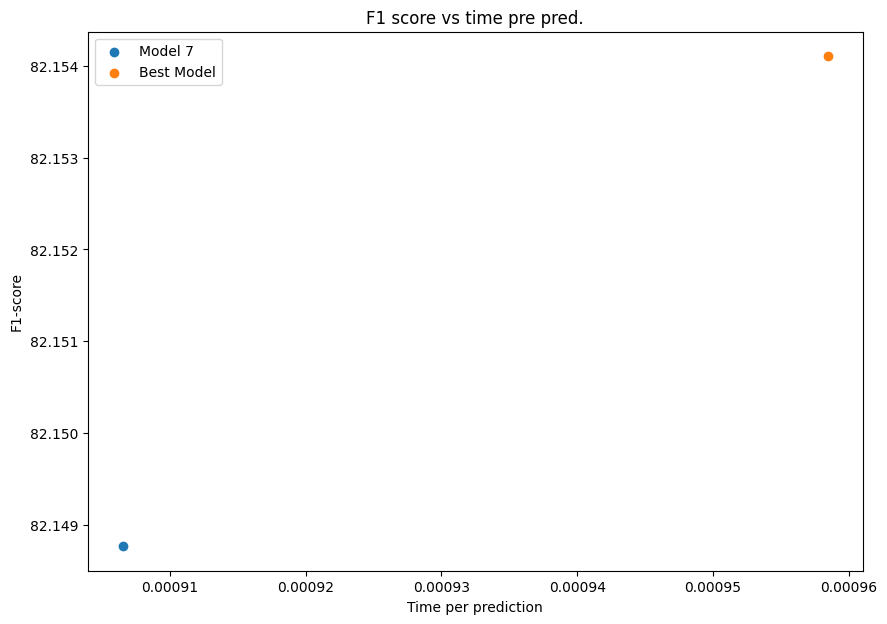

In [117]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,7))
plt.scatter(model_7_pred_time, model_7_results["f1"], label="Model 7")
plt.scatter(best_model_pred_time, best_model_results["f1"], label="Best Model")
plt.legend()
plt.title("F1 score vs time pre pred.")
plt.xlabel("Time per prediction")
plt.ylabel("F1-score")
plt.show

Take model with slow prediction but high accuracy like orange (best model) or choose the model with low accuracy but fast prediction model like blue (model 7)